<a href="https://www.kaggle.com/code/samithsachidanandan/coffee-cups-cnn-tf-improved-transfer-learning?scriptVersionId=283994090" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Published on December 04, 2025. By Prata, Marília (mpwolke)

### Acknowledgements:

[Marília Prata](https://www.kaggle.com/code/mpwolke/coffee-cups-cnn-keras)

In [1]:
!pip install protobuf==3.20.* --force-reinstall --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0


In [2]:

import numpy as np 
import pandas as pd 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import plotly.io as pio
pio.renderers.default = 'iframe'

import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px


import warnings
warnings.filterwarnings('ignore')



### Coffee Grounds

"Coffee ground" can refer to either fresh, ground coffee beans before brewing or the sediment left over after brewing. The term "coffee grounds" can also refer to something that looks like coffee grounds, such as the appearance of vomit that has been darkened by blood. The more common meaning refers to the small particles of roasted coffee beans." 

In [3]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV2, EfficientNetB0


2025-12-05 05:25:03.471823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764912303.756616      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764912303.835996      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Class_mode

https://stackoverflow.com/questions/62090714/confused-between-whether-or-not-to-change-the-class-mode-from-binary-to-categori

"So you should use categorical_crossentropy as loss function if you choose categorical for class_mode, and sparse_categorical_crossentropy if you choose sparse."

"Of course, you should change it. If you have **only 2 classes** use **class_mode='binary'** in flow_from_directory function and **binary_crossentropy** as loss. In case you have more than 2 classes, use class_mode='categorical' and categorical_crossentropy"

In [4]:
#By Arif Miah https://www.kaggle.com/code/miadul/basic-cnn

dataset_path = "/kaggle/input/turkish-coffee-cup-grounds-image-dataset"


img_size = (224, 224)
batch = 8 


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch,
    class_mode='binary',
    subset='training' 
)

val_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch,
    class_mode='binary',
    subset='validation'  
)

test_data = test_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch,
    class_mode='binary',
    shuffle=False
)

Found 25 images belonging to 2 classes.
Found 5 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## Display images

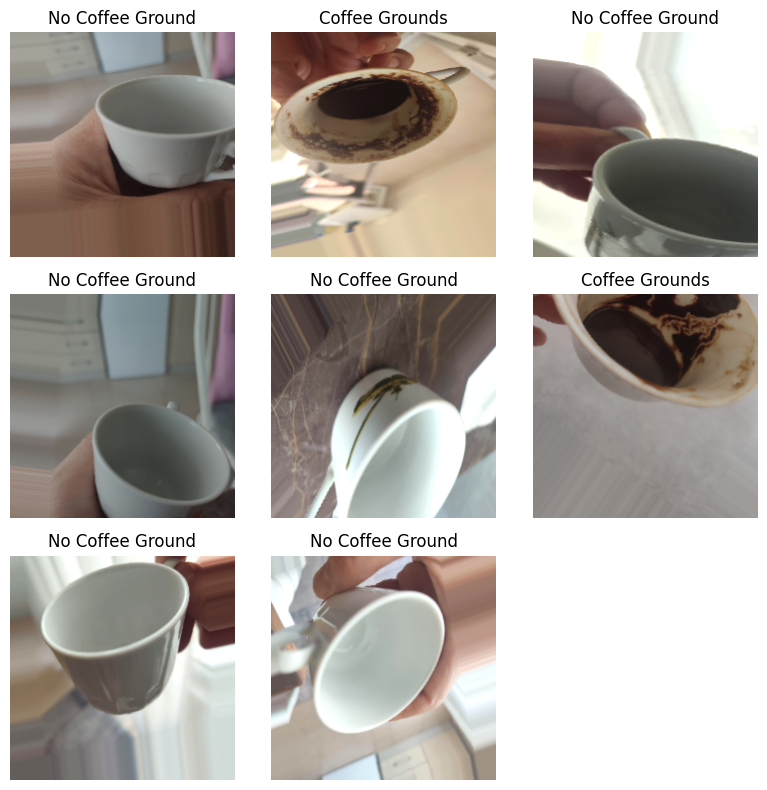

In [5]:
#By Arif Miah https://www.kaggle.com/code/miadul/basic-cnn

imgs, labels = next(train_data)


num_images = min(len(imgs), 9) 

plt.figure(figsize=(8,8))
for i in range(num_images):
    plt.subplot(3,3,i+1)
    plt.imshow(imgs[i])
    plt.title("No Coffee Ground" if labels[i] == 0 else "Coffee Grounds")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
#By Arif Miah https://www.kaggle.com/code/miadul/basic-cnn

print("Classes:", train_data.class_indices)
print("Train Samples:", train_data.samples)
print("Val Samples:", val_data.samples)
print("Test Samples:", test_data.samples)

Classes: {'NoCoffeeGround': 0, 'WithCoffeeGround': 1}
Train Samples: 25
Val Samples: 5
Test Samples: 30


## Model

 Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 2)

In [7]:
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


base_model.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

2025-12-05 05:25:23.345229: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Epochs

No GPU cause we have just 30 images.

In [8]:
history = model.fit(
    train_data,
    epochs=100,  
    validation_data=val_data,
    callbacks=[
        EarlyStopping(
            monitor='val_loss', 
            patience=15,  
            restore_best_weights=True,
            verbose=1  
        ),
        ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.5, 
            patience=7,  
            min_lr=1e-7,  
            verbose=1  
        ),
        ModelCheckpoint(  
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ],
    verbose=1
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.3653 - loss: 1.2300
Epoch 1: val_loss improved from inf to 0.58876, saving model to best_model.keras
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3723 - loss: 1.2073 - val_accuracy: 0.6000 - val_loss: 0.5888 - learning_rate: 1.0000e-04
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.5739 - loss: 0.7375
Epoch 2: val_loss did not improve from 0.58876
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step - accuracy: 0.5631 - loss: 0.7594 - val_accuracy: 0.4000 - val_loss: 0.7798 - learning_rate: 1.0000e-04
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.3457 - loss: 0.9303
Epoch 3: val_loss did not improve from 0.58876
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 0.3646 - loss: 0.9073 - val_accuracy: 0.4000 - val_loss: 0.8098 - learning_rate: 1.0000e-04
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7362 - loss: 0.6315
Epoch 4: val_loss did not improve from 0.58876
4/4 ━━━━━━━

In [9]:
loss, acc = model.evaluate(test_data)
print("Test Accuracy:", acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 1.0000 - loss: 0.0710
Test Accuracy: 1.0


In [10]:
#By Arif Miah https://www.kaggle.com/code/miadul/basic-cnn

pred = model.predict(test_data)
pred_classes = (pred > 0.5).astype("int32").reshape(-1)

true_classes = test_data.classes
class_names = ["No Coffee Grounds", "Coffee Grounds"]

print(classification_report(true_classes, pred_classes, target_names=class_names))

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 895ms/step
                   precision    recall  f1-score   support

No Coffee Grounds       1.00      1.00      1.00        16
   Coffee Grounds       1.00      1.00      1.00        14

         accuracy                           1.00        30
        macro avg       1.00      1.00      1.00        30
     weighted avg       1.00      1.00      1.00        30



## Confusion Matrix

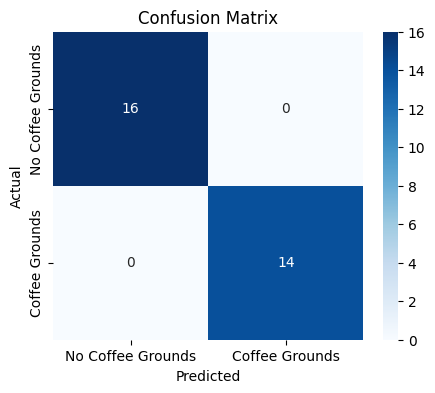

In [11]:
#By Arif Miah https://www.kaggle.com/code/miadul/basic-cnn

cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## ROC Curve

It's a right (rectangular)triangle.

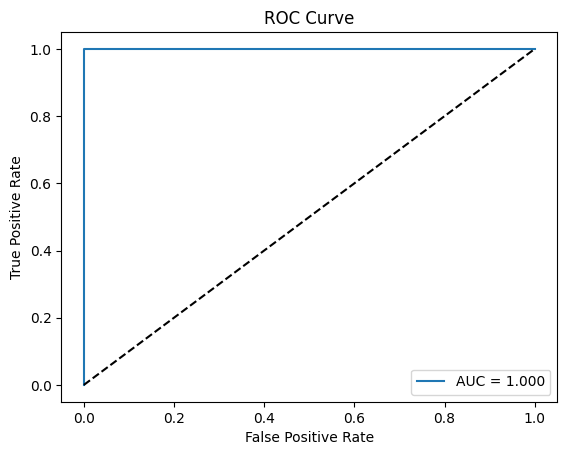

In [12]:
#By Arif Miah https://www.kaggle.com/code/miadul/basic-cnn

fpr, tpr, _ = roc_curve(true_classes, pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## History

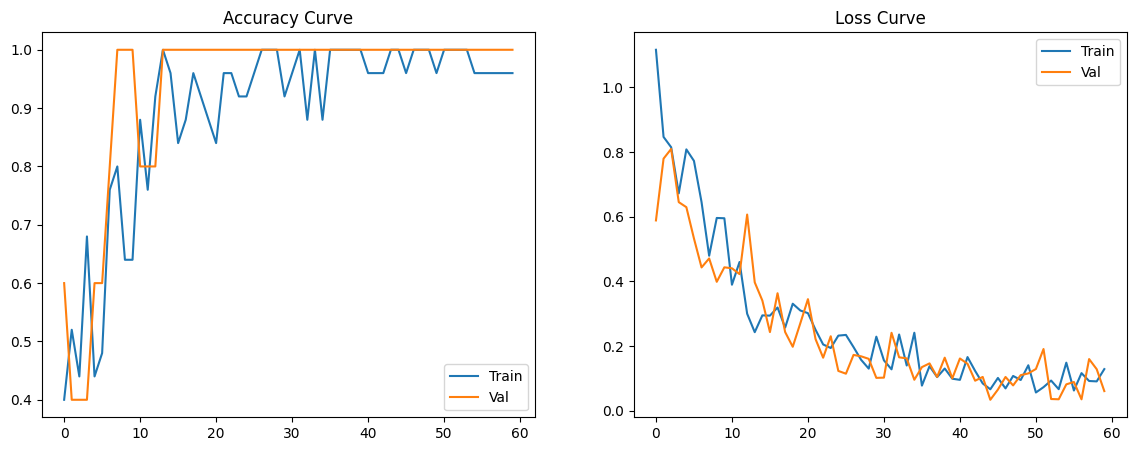

In [13]:
#By Arif Miah https://www.kaggle.com/code/miadul/basic-cnn

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Curve")
plt.legend(["Train", "Val"])

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Curve")
plt.legend(["Train", "Val"])

plt.show()

## I had to change Coffee Grounds to the 1st option to get right prediction

So, It's not a good one.

In [14]:
test_img = "/kaggle/input/turkish-coffee-cup-grounds-image-dataset/WithCoffeeGround/IMG-20241013-WA0057_jpg.rf.58d2bc7d0343ea38bb4a69714257c3c6.jpg"

img = load_img(test_img, target_size=img_size)
img_arr = img_to_array(img)/255.
img_arr = np.expand_dims(img_arr, axis=0)

p = model.predict(img_arr)[0][0]

if p > 0.5:
    print("Prediction: Coffee Grounds")
else:
    print("Prediction: No Coffee Grounds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Coffee Grounds


In [15]:
model.save("coffee_grounds_model.keras")
print("Keras Model Saved!")

Keras Model Saved!


### Acknowledgements:



[Marília Prata](https://www.kaggle.com/code/mpwolke/coffee-cups-cnn-keras)

[Arif Miah](https://www.kaggle.com/code/miadul/basic-cnn)